# Wavenet

In this tutorial, we show how to quickly set up and train an CNN regression model with the deep4cast package. The dataset we're using is from the GEFCom2014 forecasting competition and involved hourly energy load forecasting.

In [1]:
import numpy as np

import matplotlib.pyplot as plt

from deep4cast.forecasters import Forecaster
from deep4cast.topologies import WaveNet

import deep4cast.custom_metrics as metrics
from pandas import read_table

%matplotlib inline

Using TensorFlow backend.


## Data preparation

Before we can fit a model we first have to load, clean, and prepare our dataset so that the model can accept it.

In [2]:
# Load the data from file
filename = '../data/energy.csv'
df = read_table(filename, sep=',')
df = df.head(100)

# Prepare the data set
data = df[['load', 'temp']].astype('float32').values
data = np.expand_dims(data, axis=0)

# We just need a small holdout dataset for evaluation purposes
holdout = 24 # hours
train_data = data[:,:-holdout,[0]]
test_data = data[:,-holdout:,[0]]

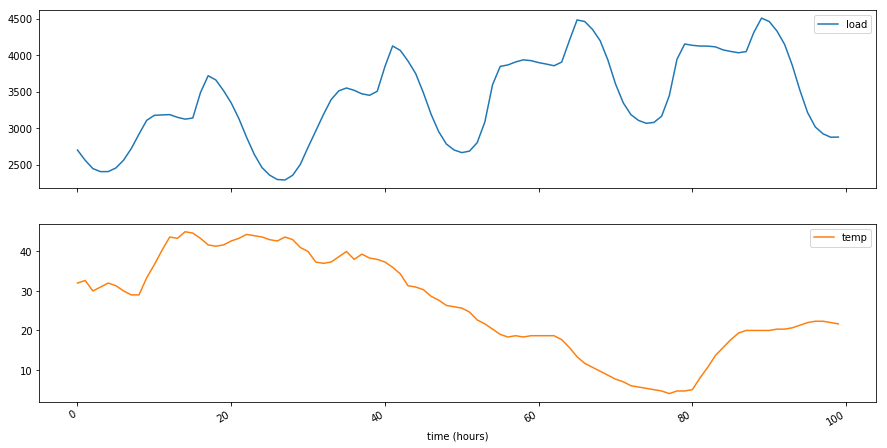

In [3]:
# Let plot the data
df.plot(subplots=True, figsize=(15, 8))
plt.xlabel('time (hours)')
plt.show()

In [4]:
topology = WaveNet(num_filters=16, num_layers=10)

In [5]:
topology.build_layers(input_shape=(24, 4), output_dim=2)

/Users/toby/cdna/deep4cast/deep4cast/topologies.py:44: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(filters=16, kernel_size=2, strides=1, padding="causal", dilation_rate=1, name="dilated_1", activation="relu", use_bias=True)`
  activation=self.activation


Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead


/Users/toby/cdna/deep4cast/deep4cast/topologies.py:53: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(filters=16, kernel_size=1, name="skip_1", padding="same", use_bias=True)`
  bias=True
/Users/toby/cdna/deep4cast/deep4cast/topologies.py:55: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  outputs = keras.layers.Merge(mode='sum')([outputs, skip])
/Users/toby/cdna/deep4cast/deep4cast/topologies.py:79: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(filters=16, kernel_size=2, strides=1, padding="causal", dilation_rate=2, name="dilated_2", activation="relu", use_bias=True)`
  activation=self.activation
/Users/toby/cdna/deep4cast/deep4cast/topologies.py:82: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  outputs = keras.layers.Merg

In [6]:
topology.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 24, 4)        0                                            
__________________________________________________________________________________________________
dilated_1 (Conv1D)              (None, 24, 16)       144         input_1[0][0]                    
__________________________________________________________________________________________________
concrete_dropout_1 (ConcreteDro (None, 24, 16)       1           dilated_1[0][0]                  
__________________________________________________________________________________________________
skip_1 (Conv1D)                 (None, 24, 16)       80          input_1[0][0]                    
__________________________________________________________________________________________________
merge_1 (M

In [7]:
forecaster = Forecaster(
    topology,
    lag=48,  # This is the number of time steps used to predict the future for each data point
    horizon=24,  # This is how many time steps into the future we want to produce
    optimizer='nadam',  # Which optimizer the forecaster is using
    loss='heteroscedastic_gaussian', 
    lr=0.001,  # This is the learning rate for the optimizer
    max_epochs=50,  # Maximum number of epochs that the optimizer will perform
    batch_size=32
)

In [8]:
forecaster.fit(train_data, targets=[0], patience=5, verbose=1)  # patience is the number of epochs to wait until early stopping is executed

TypeError: build() got an unexpected keyword argument 'output_shape'

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(forecaster.history.epoch, forecaster.history.history['loss'], 'r')
plt.plot(forecaster.history.epoch, forecaster.history.history['val_loss'], 'blue') 
plt.xlabel('Epoch number')
plt.ylabel('Loss')
plt.legend(['loss', 'validation loss'])

As before, we can use the forecaster to make predictions

In [ ]:
predictions = forecaster.predict(data=train_data, n_samples=100)

In [ ]:
print('MSE: {}'.format(round(metrics.mse(predictions['mean'], test_data[:,:,:1]), 2)))
print('MAPE: {}%'.format(round(metrics.mape(predictions['mean'], test_data[:,:,:1]), 2)))
print('SMAPE: {}%'.format(round(metrics.smape(predictions['mean'], test_data[:,:,:1]), 2)))

In [ ]:
# We're printing the test set data and the predictions for the load data
plt.plot(predictions['samples'][:,0,:,0].T, 'g', alpha=0.01)
plt.plot(test_data[0,:,0].T, 'k')
plt.plot(predictions['mean'][0,:,0], 'r')
plt.plot(predictions['lower_quantile'][0,:,0], 'r--')
plt.plot(predictions['upper_quantile'][0,:,0], 'r--')
plt.xlabel('time (hours)')
plt.ylabel('Predicted and actual load')
plt.tight_layout()

In [ ]:
from keras.layers import Input

In [ ]:
Input(shape=(12, 2))